# Bootcamp Competition


## About the dataset

This dataset consists of a train.csv file which contains the image_id and class_6 columns. The image_id is the unique id for each image of yoga pose and the class_6 classes of yoga poses to which that image belongs. The images for training and testing are present in the images folder. The aim of this competition is to predict the class_6 correctly for the test_images and submit the response as csv file submission.csv.
You are required to use the train.csv file to read the images from the folder provided and train your algorithms to learn the category of the yoga pose provided in class_6 column in train.csv file.

## What am I predicting?
You would be training your model based on the train.csv (training dataset) and then would be predicting the class_6 value for each test image to create a submission.

## Files
train.csv - the provided training data set
images - the folder which consists of train_images and test_images.
sample_submission.csv - a sample submission file in the correct format.
## Columns
image_id: The unique ID for each image of yoga pose.
class_6: The class to which each yoga pose image belongs. [target variable]
The training dataset provided could be read using the read_csv() function in the pandas module.

### Inspect input data

In [1]:
import os
import zipfile
import random
from shutil import copyfile

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import missingno as msno

import csv
import pandas as pd
import numpy as np

import rembg
from PIL import Image, ImageFilter, ImageEnhance, ImageOps
from PIL.ExifTags import TAGS

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential, Model
from keras.layers import Activation, Dropout, Dense, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from keras.callbacks import EarlyStopping

os.chdir(os.getcwd())
local_zip = 'ukraine-ml-bootcamp-2023.zip'
main_dir = 'ukraine-ml-bootcamp-2023'

In [2]:
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall(main_dir)
zip_ref.close()
os.listdir (main_dir)

['images', 'sample_submission.csv', 'train.csv']

In [3]:
os.listdir (os.path.join(main_dir, 'images'))

['test_images', 'train_images']

In [4]:
train_images_path = os.path.join(main_dir, 'images','train_images')
test_images_path = os.path.join(main_dir, 'images','test_images')

print('number of training images = ',len(os.listdir(train_images_path)))
print('number of test images = ',len(os.listdir(test_images_path)))

number of training images =  2360
number of test images =  756


data first 10 rows: 
                                image_id  class_6
0  1daf45401342ac321c0aa5668f51d004.jpg        5
1  7e15c14f0b25766d0b7378f1d5328e99.jpg        4
2  1dc97053cf67cb8e51c983abb0021083.jpg        4
3  0ceaf686d3b9c1db537fed12b568670d.jpg        1
4  73adbf71f0adcf89c94339f6a6a92b61.jpg        0
5  44e1f36fcda7633399ba6181977efc37.jpg        1
6  0b3066a18cafb2598146428c305980cc.jpg        5
7  6bc83759703dfd00dab54965aeabbcd2.jpg        5
8  336c1553e7c64db5d11bf57c7ecc284c.jpg        2
9  4b93aeec59321bc1136d92d2430444b3.jpg        2 

data shape: 
 (2360, 2) 

columns: 
 Index(['image_id', 'class_6'], dtype='object') 



<Axes: >

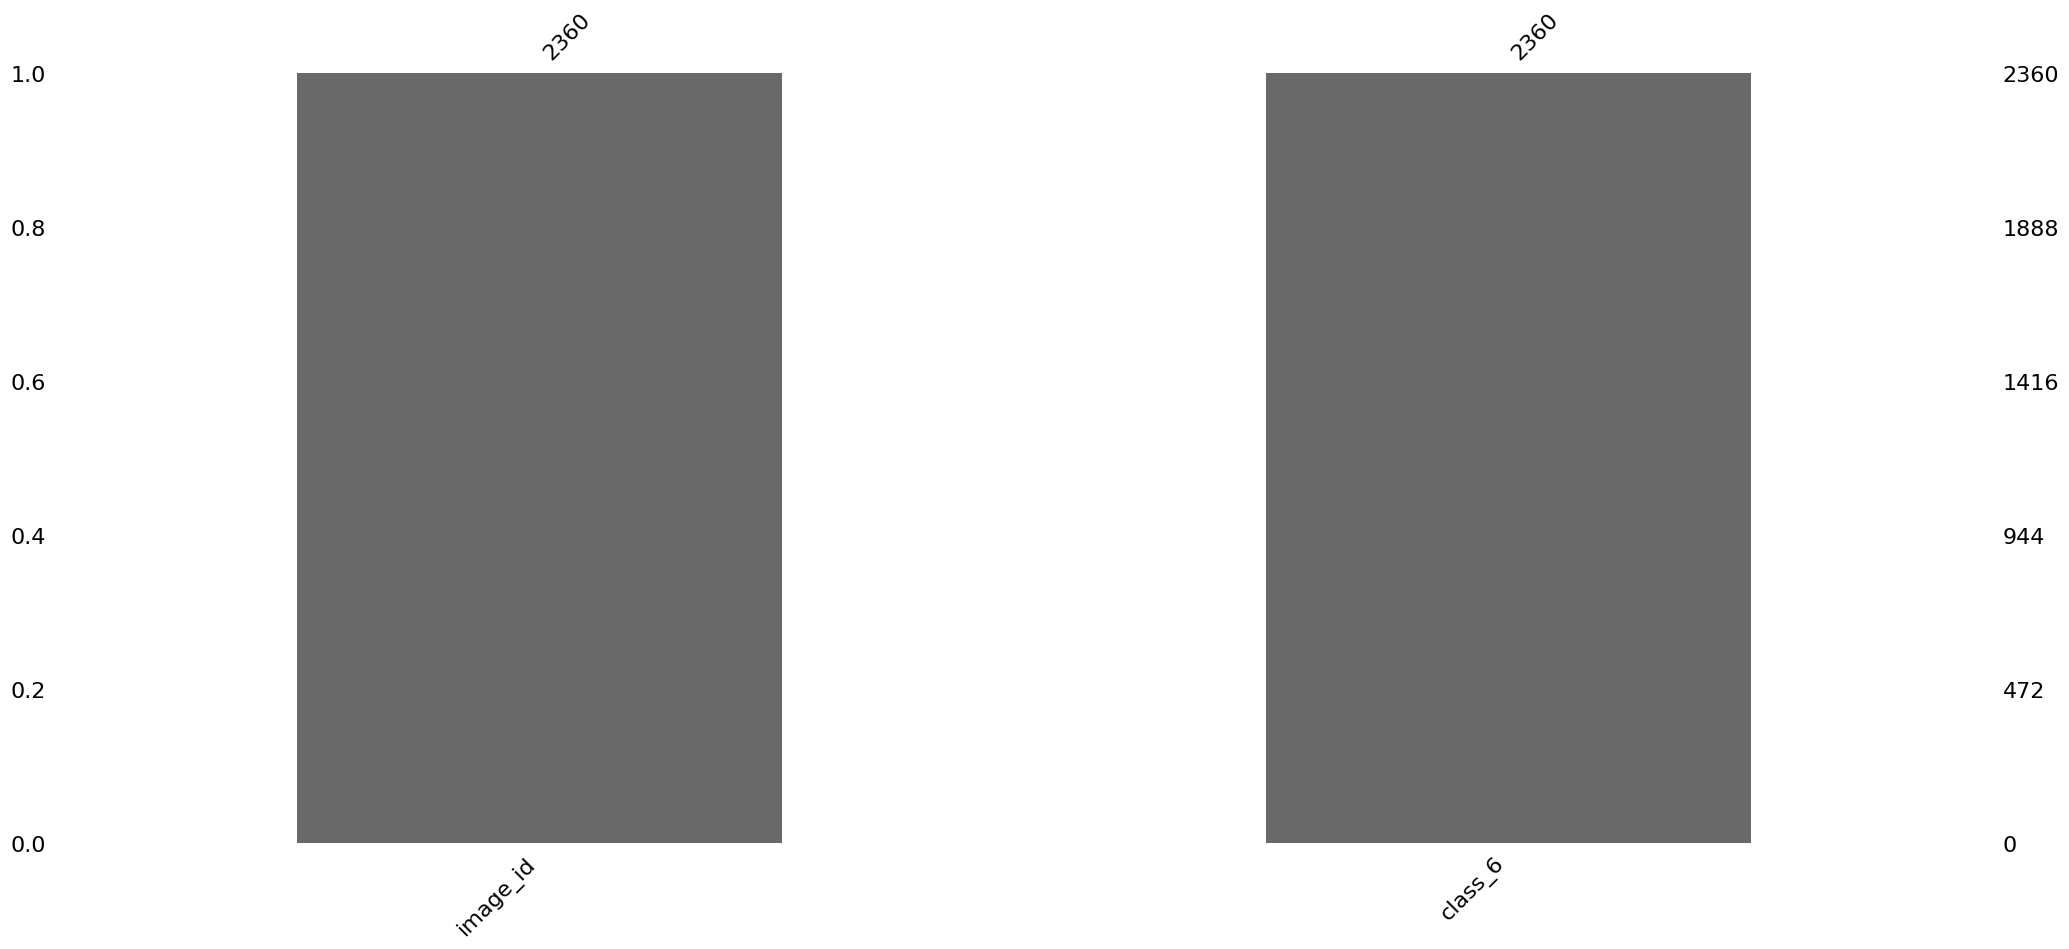

In [5]:
train_csv=pd.read_csv(os.path.join(main_dir, 'train.csv'))
print ("data first 10 rows:",'\n',train_csv.head(10),'\n')
print ("data shape:",'\n',train_csv.shape,'\n')
print ("columns:",'\n',train_csv.columns,'\n')

msno.bar(train_csv)

In [6]:
images_dir = 'ukraine-ml-bootcamp-2023/images'
train_images_dir= 'ukraine-ml-bootcamp-2023/images/train_images'
def parse_data_from_input(filename):
    main_dictionary={}
    with open(filename) as file:
        csv_reader = csv.reader(file, delimiter=',')
        next(csv_reader)
        for row in csv_reader:
            main_dictionary[row[0]]=int(row[1])
    return main_dictionary

In [7]:
training_images_dictionary=parse_data_from_input(main_dir+'\\train.csv')

print('10 training_images: ',list(training_images_dictionary.keys())[:10])
print('10 training_classes: ',list(training_images_dictionary.values())[:10])

10 training_images:  ['1daf45401342ac321c0aa5668f51d004.jpg', '7e15c14f0b25766d0b7378f1d5328e99.jpg', '1dc97053cf67cb8e51c983abb0021083.jpg', '0ceaf686d3b9c1db537fed12b568670d.jpg', '73adbf71f0adcf89c94339f6a6a92b61.jpg', '44e1f36fcda7633399ba6181977efc37.jpg', '0b3066a18cafb2598146428c305980cc.jpg', '6bc83759703dfd00dab54965aeabbcd2.jpg', '336c1553e7c64db5d11bf57c7ecc284c.jpg', '4b93aeec59321bc1136d92d2430444b3.jpg']
10 training_classes:  [5, 4, 4, 1, 0, 1, 5, 5, 2, 2]


In [8]:
temp=[x for x in list(training_images_dictionary.keys()) if x not in os.listdir(train_images_dir)]
print(len(temp))

train_images_pathes=[]
for i in list(training_images_dictionary.keys()):
    train_images_pathes.append(os.path.join(train_images_dir, i))

print(train_images_pathes[0])

0
ukraine-ml-bootcamp-2023/images/train_images\1daf45401342ac321c0aa5668f51d004.jpg


In [9]:
list_Filename=[]
im_sq=[]
im_h=[]
im_w=[]
for i in train_images_pathes:
    image = Image.open(i)
    list_Filename.append(image.filename)   
    im_sq.append(image.height*image.width)
    im_h.append(image.height)
    im_w.append(image.width)
    
train_info_dict = {
    "Filename": list_Filename,
    "class_6":list(training_images_dictionary.values()),
    "Image_Size": im_sq,
    "Image_Hight": im_h,
    "Image_Weight": im_w
}

av=np.average(list(train_info_dict.values())[2])
print(av)

counts = np.bincount(im_h)
print('moda height: ',np.argmax(counts))
counts2 = np.bincount(im_w)
print('moda wight: ',np.argmax(counts2))

936419.2894067797
moda height:  640
moda wight:  600


In [10]:
train_dataframe=pd.DataFrame.from_dict(train_info_dict)
print ("data first 10 rows:",'\n',train_dataframe.head(10),'\n')
print ("columns:",'\n',train_dataframe.describe(),'\n')

data first 10 rows: 
                                             Filename  class_6  Image_Size  \
0  ukraine-ml-bootcamp-2023/images/train_images\1...        5    19513870   
1  ukraine-ml-bootcamp-2023/images/train_images\7...        4     3943522   
2  ukraine-ml-bootcamp-2023/images/train_images\1...        4      809193   
3  ukraine-ml-bootcamp-2023/images/train_images\0...        1       89400   
4  ukraine-ml-bootcamp-2023/images/train_images\7...        0      360640   
5  ukraine-ml-bootcamp-2023/images/train_images\4...        1      884736   
6  ukraine-ml-bootcamp-2023/images/train_images\0...        5      356510   
7  ukraine-ml-bootcamp-2023/images/train_images\6...        5       55696   
8  ukraine-ml-bootcamp-2023/images/train_images\3...        2       39648   
9  ukraine-ml-bootcamp-2023/images/train_images\4...        2      409600   

   Image_Hight  Image_Weight  
0         3607          5410  
1         1738          2269  
2          791          1023  
3     

In [11]:
def parse_data_from_orig(path, lab, filename):
    training_images_orig={}
    with open(filename) as file:
        csv_reader = csv.reader(file, delimiter=',')
        next(csv_reader)
        for row in csv_reader:
            training_images_orig[os.path.join(path, lab+row[0])]=(int(row[1]),Image.open(os.path.join(path, lab+row[0])).height*
                                                              Image.open(os.path.join(path, lab+row[0])).width)
    return training_images_orig
    
training_images_o=parse_data_from_orig(train_images_dir,'',main_dir+'\\train.csv')

print('10 training_images: ',list(training_images_o.keys())[:5])
print('10 training_classes: ',list(training_images_o.values())[:5])

10 training_images:  ['ukraine-ml-bootcamp-2023/images/train_images\\1daf45401342ac321c0aa5668f51d004.jpg', 'ukraine-ml-bootcamp-2023/images/train_images\\7e15c14f0b25766d0b7378f1d5328e99.jpg', 'ukraine-ml-bootcamp-2023/images/train_images\\1dc97053cf67cb8e51c983abb0021083.jpg', 'ukraine-ml-bootcamp-2023/images/train_images\\0ceaf686d3b9c1db537fed12b568670d.jpg', 'ukraine-ml-bootcamp-2023/images/train_images\\73adbf71f0adcf89c94339f6a6a92b61.jpg']
10 training_classes:  [(5, 19513870), (4, 3943522), (4, 809193), (1, 89400), (0, 360640)]


### Split data

In [12]:
root_dir=os.path.join(images_dir, 'go_train_images')
if os.path.exists(root_dir):
    shutil.rmtree(root_dir)

def create_train_val_dirs(root_path):

    os.makedirs(os.path.join(root_path,'training'))
    os.makedirs(os.path.join(root_path,'validation'))
    
    os.makedirs(os.path.join(root_path,'training/0'))
    os.makedirs(os.path.join(root_path,'training/1'))
    os.makedirs(os.path.join(root_path,'training/2'))
    os.makedirs(os.path.join(root_path,'training/3'))
    os.makedirs(os.path.join(root_path,'training/4'))
    os.makedirs(os.path.join(root_path,'training/5'))    
    
    os.makedirs(os.path.join(root_path,'validation/0'))
    os.makedirs(os.path.join(root_path,'validation/1'))
    os.makedirs(os.path.join(root_path,'validation/2'))
    os.makedirs(os.path.join(root_path,'validation/3'))
    os.makedirs(os.path.join(root_path,'validation/4'))
    os.makedirs(os.path.join(root_path,'validation/5'))  
try:
    create_train_val_dirs(root_path=root_dir)
except FileExistsError:
    print("You should not be seeing this since the upper directory is removed beforehand")
for rootdir, dirs, files in os.walk(root_dir):
    for subdir in dirs:
        print(os.path.join(rootdir, subdir))

ukraine-ml-bootcamp-2023/images\go_train_images\training
ukraine-ml-bootcamp-2023/images\go_train_images\validation
ukraine-ml-bootcamp-2023/images\go_train_images\training\0
ukraine-ml-bootcamp-2023/images\go_train_images\training\1
ukraine-ml-bootcamp-2023/images\go_train_images\training\2
ukraine-ml-bootcamp-2023/images\go_train_images\training\3
ukraine-ml-bootcamp-2023/images\go_train_images\training\4
ukraine-ml-bootcamp-2023/images\go_train_images\training\5
ukraine-ml-bootcamp-2023/images\go_train_images\validation\0
ukraine-ml-bootcamp-2023/images\go_train_images\validation\1
ukraine-ml-bootcamp-2023/images\go_train_images\validation\2
ukraine-ml-bootcamp-2023/images\go_train_images\validation\3
ukraine-ml-bootcamp-2023/images\go_train_images\validation\4
ukraine-ml-bootcamp-2023/images\go_train_images\validation\5


In [13]:
def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, SPLIT_SIZE):
    zero_list=[img for img in SOURCE_DIR if os.path.getsize(img)==0]
    for i in zero_list:
        print(i, ' is zero length, so ignoring.')

    folder_list=[img for img in SOURCE_DIR if img not in zero_list]

    folder_randomizer = random.sample(folder_list,len(folder_list))

    len_train=round(SPLIT_SIZE*len(folder_list))

    for i in folder_randomizer[:len_train]:
        copyfile(i, os.path.join(TRAINING_DIR, os.path.split(i)[1]))
        
    for i in folder_randomizer[len_train:]:
        copyfile(i, os.path.join(VALIDATION_DIR, os.path.split(i)[1]))

In [14]:
# Define paths
SOURCE_DIR_0 = [k for k,v in training_images_o.items() if v[0] == 0 and v[1] <= av]
SOURCE_DIR_1 = [k for k,v in training_images_o.items() if v[0] == 1 and v[1] <= av]
SOURCE_DIR_2 = [k for k,v in training_images_o.items() if v[0] == 2 and v[1] <= av]
SOURCE_DIR_3 = [k for k,v in training_images_o.items() if v[0] == 3 and v[1] <= av]
SOURCE_DIR_4 = [k for k,v in training_images_o.items() if v[0] == 4 and v[1] <= av]
SOURCE_DIR_5 = [k for k,v in training_images_o.items() if v[0] == 5 and v[1] <= av]

SOURCE_DIR_0_1 = [k for k,v in training_images_o.items() if v[0] == 0 and v[1] > av]
SOURCE_DIR_1_1 = [k for k,v in training_images_o.items() if v[0] == 1 and v[1] > av]
SOURCE_DIR_2_1 = [k for k,v in training_images_o.items() if v[0] == 2 and v[1] > av]
SOURCE_DIR_3_1 = [k for k,v in training_images_o.items() if v[0] == 3 and v[1] > av]
SOURCE_DIR_4_1 = [k for k,v in training_images_o.items() if v[0] == 4 and v[1] > av]
SOURCE_DIR_5_1 = [k for k,v in training_images_o.items() if v[0] == 5 and v[1] > av]

TRAINING_DIR = os.path.join(root_dir,'training')
VALIDATION_DIR = os.path.join(root_dir,'validation')

TRAINING_0_DIR = os.path.join(TRAINING_DIR, "0/")
TRAINING_1_DIR = os.path.join(TRAINING_DIR, "1/")
TRAINING_2_DIR = os.path.join(TRAINING_DIR, "2/")
TRAINING_3_DIR = os.path.join(TRAINING_DIR, "3/")
TRAINING_4_DIR = os.path.join(TRAINING_DIR, "4/")
TRAINING_5_DIR = os.path.join(TRAINING_DIR, "5/")

VALIDATION_0_DIR = os.path.join(VALIDATION_DIR, "0/")
VALIDATION_1_DIR = os.path.join(VALIDATION_DIR, "1/")
VALIDATION_2_DIR = os.path.join(VALIDATION_DIR, "2/")
VALIDATION_3_DIR = os.path.join(VALIDATION_DIR, "3/")
VALIDATION_4_DIR = os.path.join(VALIDATION_DIR, "4/")
VALIDATION_5_DIR = os.path.join(VALIDATION_DIR, "5/")


# Empty directories in case you run this cell multiple times
if len(os.listdir(TRAINING_0_DIR)) > 0:
    for file in os.scandir(TRAINING_0_DIR):
        os.remove(file.path)
if len(os.listdir(TRAINING_1_DIR)) > 0:
    for file in os.scandir(TRAINING_1_DIR):
        os.remove(file.path)
if len(os.listdir(TRAINING_2_DIR)) > 0:
    for file in os.scandir(TRAINING_2_DIR):
        os.remove(file.path)
if len(os.listdir(TRAINING_3_DIR)) > 0:
    for file in os.scandir(TRAINING_4_DIR):
        os.remove(file.path)
if len(os.listdir(TRAINING_4_DIR)) > 0:
    for file in os.scandir(TRAINING_4_DIR):
        os.remove(file.path)
if len(os.listdir(TRAINING_5_DIR)) > 0:
    for file in os.scandir(TRAINING_5_DIR):
        os.remove(file.path)
        
if len(os.listdir(VALIDATION_0_DIR)) > 0:
    for file in os.scandir(VALIDATION_0_DIR):
        os.remove(file.path)
if len(os.listdir(VALIDATION_1_DIR)) > 0:
    for file in os.scandir(VALIDATION_1_DIR):
        os.remove(file.path)
if len(os.listdir(VALIDATION_2_DIR)) > 0:
    for file in os.scandir(VALIDATION_2_DIR):
        os.remove(file.path)
if len(os.listdir(VALIDATION_3_DIR)) > 0:
    for file in os.scandir(VALIDATION_4_DIR):
        os.remove(file.path)
if len(os.listdir(VALIDATION_4_DIR)) > 0:
    for file in os.scandir(VALIDATION_4_DIR):
        os.remove(file.path)
if len(os.listdir(VALIDATION_5_DIR)) > 0:
    for file in os.scandir(VALIDATION_5_DIR):
        os.remove(file.path)

# Define proportion of images used for training
split_size = .8

# Run the function
# NOTE: Messages about zero length images should be printed out
split_data(SOURCE_DIR_0, TRAINING_0_DIR, VALIDATION_0_DIR, split_size)
split_data(SOURCE_DIR_1, TRAINING_1_DIR, VALIDATION_1_DIR, split_size)
split_data(SOURCE_DIR_2, TRAINING_2_DIR, VALIDATION_2_DIR, split_size)
split_data(SOURCE_DIR_3, TRAINING_3_DIR, VALIDATION_3_DIR, split_size)
split_data(SOURCE_DIR_4, TRAINING_4_DIR, VALIDATION_4_DIR, split_size)
split_data(SOURCE_DIR_5, TRAINING_5_DIR, VALIDATION_5_DIR, split_size)

split_data(SOURCE_DIR_0_1, TRAINING_0_DIR, VALIDATION_0_DIR, split_size)
split_data(SOURCE_DIR_1_1, TRAINING_1_DIR, VALIDATION_1_DIR, split_size)
split_data(SOURCE_DIR_2_1, TRAINING_2_DIR, VALIDATION_2_DIR, split_size)
split_data(SOURCE_DIR_3_1, TRAINING_3_DIR, VALIDATION_3_DIR, split_size)
split_data(SOURCE_DIR_4_1, TRAINING_4_DIR, VALIDATION_4_DIR, split_size)
split_data(SOURCE_DIR_5_1, TRAINING_5_DIR, VALIDATION_5_DIR, split_size)

In [15]:
# Your function should perform copies rather than moving images so original directories should contain unchanged images
print(f"\n\nOriginal 0 directory has {len(SOURCE_DIR_0)+len(SOURCE_DIR_0_1)} images")
print(f"\n\nOriginal 1 directory has {len(SOURCE_DIR_1)+len(SOURCE_DIR_1_1)} images")
print(f"\n\nOriginal 2 directory has {len(SOURCE_DIR_2)+len(SOURCE_DIR_2_1)} images")
print(f"\n\nOriginal 3 directory has {len(SOURCE_DIR_3)+len(SOURCE_DIR_3_1)} images")
print(f"\n\nOriginal 4 directory has {len(SOURCE_DIR_4)+len(SOURCE_DIR_4_1)} images")
print(f"\n\nOriginal 5 directory has {len(SOURCE_DIR_5)+len(SOURCE_DIR_5_1)} images")

# Training and validation splits. Check that the number of images matches the expected output.
print(f"There are {len(os.listdir(TRAINING_0_DIR))} images of 0 for training")
print(f"There are {len(os.listdir(TRAINING_1_DIR))} images of 1 for training")
print(f"There are {len(os.listdir(TRAINING_2_DIR))} images of 2 for training")
print(f"There are {len(os.listdir(TRAINING_3_DIR))} images of 3 for training")
print(f"There are {len(os.listdir(TRAINING_4_DIR))} images of 4 for training")
print(f"There are {len(os.listdir(TRAINING_5_DIR))} images of 5 for training")

print(f"There are {len(os.listdir(VALIDATION_0_DIR))} images of 0 for validation")
print(f"There are {len(os.listdir(VALIDATION_1_DIR))} images of 1 for validation")
print(f"There are {len(os.listdir(VALIDATION_2_DIR))} images of 2 for validation")
print(f"There are {len(os.listdir(VALIDATION_3_DIR))} images of 3 for validation")
print(f"There are {len(os.listdir(VALIDATION_4_DIR))} images of 4 for validation")
print(f"There are {len(os.listdir(VALIDATION_5_DIR))} images of 5 for validation")
train_len=len(os.listdir(TRAINING_0_DIR))+len(os.listdir(TRAINING_1_DIR))+len(os.listdir(TRAINING_2_DIR))+len(os.listdir(TRAINING_3_DIR))+len(os.listdir(TRAINING_4_DIR))+len(os.listdir(TRAINING_5_DIR))
val_len=trin_len=len(os.listdir(VALIDATION_0_DIR))+len(os.listdir(VALIDATION_1_DIR))+len(os.listdir(VALIDATION_2_DIR))+len(os.listdir(VALIDATION_3_DIR))+len(os.listdir(VALIDATION_4_DIR))+len(os.listdir(VALIDATION_5_DIR))
print('training:',train_len)
print('validation',val_len)



Original 0 directory has 505 images


Original 1 directory has 489 images


Original 2 directory has 310 images


Original 3 directory has 193 images


Original 4 directory has 603 images


Original 5 directory has 260 images
There are 404 images of 0 for training
There are 391 images of 1 for training
There are 248 images of 2 for training
There are 154 images of 3 for training
There are 482 images of 4 for training
There are 208 images of 5 for training
There are 101 images of 0 for validation
There are 98 images of 1 for validation
There are 62 images of 2 for validation
There are 39 images of 3 for validation
There are 121 images of 4 for validation
There are 52 images of 5 for validation
training: 1887
validation 473


## Balance the amount of data in classes

In [30]:
segmented=[]
edge=[]
blur=[]

In [32]:
def increase_segmented(training_filtered_dir):    
    '''remove background and flip horisontally'''
    global segmented
    for j in range(len(os.listdir(training_filtered_dir))):
        i=random.choice([os.path.join(training_filtered_dir, i) for i in os.listdir(training_filtered_dir)
                                if i.split('_')[0] not in ['segmented','edge','blur']
                                 and i not in segmented])
        if len(os.listdir(training_filtered_dir))<482:
            input_image = Image.open(i)    
            # Convert the input image to a numpy array
            input_array = np.array(input_image)    
            # Apply background removal using rembg
            output_array = rembg.remove(input_array)    
            # Create a PIL Image from the output array
            output_image = Image.fromarray(output_array)    
            rgb_im = ImageEnhance.Brightness(output_image.convert('RGB')).enhance(1.5)
            rgb_im = rgb_im.transpose(Image.FLIP_LEFT_RIGHT)
            rgb_im.save(os.path.join(training_filtered_dir,'segmented_'+os.path.split(i)[1]))
            segmented.append(os.path.join(training_filtered_dir, i))
        else:
            break

In [33]:
increase_segmented(TRAINING_0_DIR)

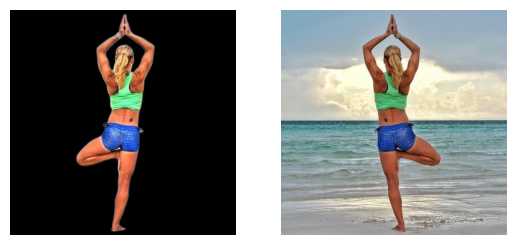

In [77]:
img_path=random.choice([os.path.join(TRAINING_0_DIR, i) for i in os.listdir(TRAINING_0_DIR)
                                if i.split('_')[0]=='segmented'])

sp = plt.subplot(1, 2, 1)
sp.axis('Off') # Don't show axes (or gridlines)
img = mpimg.imread(img_path)
plt.imshow(img)
sp = plt.subplot(1, 2, 2)
sp.axis('Off')
img2 = mpimg.imread(os.path.join(TRAINING_0_DIR, os.path.split(img_path)[1].split('_')[1]))
plt.imshow(img2) 
plt.show()


In [78]:
increase_segmented(TRAINING_1_DIR)
increase_segmented(TRAINING_2_DIR)
increase_segmented(TRAINING_3_DIR)
increase_segmented(TRAINING_5_DIR)

In [81]:
def increase_edge(training_filtered_dir):
    '''crop edges, remove background and leave only contours'''
    global edge
    for j in range(len(os.listdir(training_filtered_dir))):
        i=random.choice([os.path.join(training_filtered_dir, i) for i in os.listdir(training_filtered_dir)
                                if i.split('_')[0] not in ['segmented','edge','blur']
                                  and i not in edge])
        if len(os.listdir(training_filtered_dir))<482:
            input_image = Image.open(i) 
            
            width, height = input_image.size             
            left = width / 8
            top = height / 4
            right = 7 * width / 8
            bottom = 7 * height / 8             
            # Cropped image of above dimension
            # (It will not change original image)
            input_image = input_image.crop((left, top, right, bottom))
            
            # Convert the input image to a numpy array
            input_array = np.array(input_image)    
            # Apply background removal using rembg
            output_array = rembg.remove(input_array)    
            # Create a PIL Image from the output array
            output_image = Image.fromarray(output_array)    
            g_im = ImageEnhance.Contrast(output_image.convert('L')).enhance(3)
            g_im.filter(ImageFilter.CONTOUR).save(os.path.join(training_filtered_dir,'edge_'+os.path.split(i)[1]))
            edge.append(os.path.join(training_filtered_dir, i))
        else:
            break

In [82]:
increase_edge(TRAINING_2_DIR)

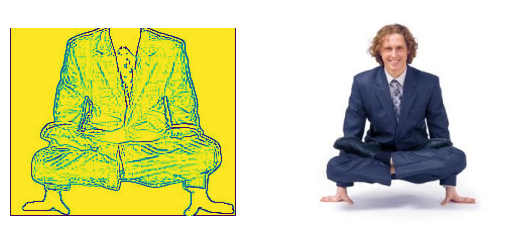

In [85]:
img_path=random.choice([os.path.join(TRAINING_2_DIR, i) for i in os.listdir(TRAINING_2_DIR)
                                if i.split('_')[0]=='edge'])

sp = plt.subplot(1, 2, 1)
sp.axis('Off') # Don't show axes (or gridlines)
img = mpimg.imread(img_path)
plt.imshow(img)
sp = plt.subplot(1, 2, 2)
sp.axis('Off')
img2 = mpimg.imread(os.path.join(TRAINING_2_DIR, os.path.split(img_path)[1].split('_')[1]))
plt.imshow(img2) 
plt.show()

In [86]:
increase_edge(TRAINING_3_DIR)
increase_edge(TRAINING_5_DIR)

In [96]:
def increase_blur(training_filtered_dir):  
    '''blur and horisontal flip'''
    global blur
    for j in range(len(os.listdir(training_filtered_dir))):
        i=random.choice([os.path.join(training_filtered_dir, i) for i in os.listdir(training_filtered_dir)
                        if i.split('_')[0] not in ['segmented','edge','blur']
                          and i not in blur])
        if len(os.listdir(training_filtered_dir))<482:
            im = Image.open(i)        
            blurImage = im.filter(ImageFilter.BLUR)
            blurImage = blurImage.transpose(Image.FLIP_LEFT_RIGHT)
            blurImage.save(os.path.join(training_filtered_dir,'blur_'+os.path.split(i)[1]))
            blur.append(os.path.join(training_filtered_dir, i))
        else:
            break

In [97]:
increase_blur(TRAINING_3_DIR)

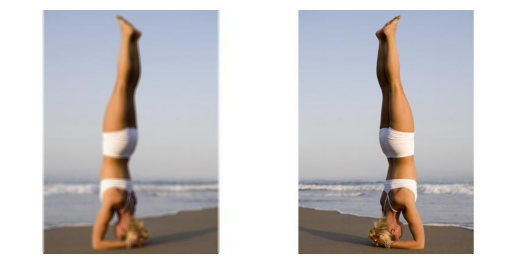

In [106]:
img_path=random.choice([os.path.join(TRAINING_3_DIR, i) for i in os.listdir(TRAINING_3_DIR)
                                if i.split('_')[0]=='blur'])

sp = plt.subplot(1, 2, 1)
sp.axis('Off') # Don't show axes (or gridlines)
img = mpimg.imread(img_path)
plt.imshow(img)
sp = plt.subplot(1, 2, 2)
sp.axis('Off')
img2 = mpimg.imread(os.path.join(TRAINING_3_DIR, os.path.split(img_path)[1].split('_')[1]))
plt.imshow(img2) 
plt.show()

In [82]:
'''def increasing(folder):
    while len(os.listdir(folder))<700:
        random.choice([ increase_segmented(folder),
                        increase_edge(folder),
                        increase_blur(folder)])'''

In [3]:
images_dir = 'ukraine-ml-bootcamp-2023/images'
train_images_dir= 'ukraine-ml-bootcamp-2023/images/train_images'
root_dir=os.path.join(images_dir, 'go_train_images')
TRAINING_DIR = os.path.join(root_dir,'training')
VALIDATION_DIR = os.path.join(root_dir,'validation')

TRAINING_0_DIR = os.path.join(TRAINING_DIR, "0/")
TRAINING_1_DIR = os.path.join(TRAINING_DIR, "1/")
TRAINING_2_DIR = os.path.join(TRAINING_DIR, "2/")
TRAINING_3_DIR = os.path.join(TRAINING_DIR, "3/")
TRAINING_4_DIR = os.path.join(TRAINING_DIR, "4/")
TRAINING_5_DIR = os.path.join(TRAINING_DIR, "5/")

VALIDATION_0_DIR = os.path.join(VALIDATION_DIR, "0/")
VALIDATION_1_DIR = os.path.join(VALIDATION_DIR, "1/")
VALIDATION_2_DIR = os.path.join(VALIDATION_DIR, "2/")
VALIDATION_3_DIR = os.path.join(VALIDATION_DIR, "3/")
VALIDATION_4_DIR = os.path.join(VALIDATION_DIR, "4/")
VALIDATION_5_DIR = os.path.join(VALIDATION_DIR, "5/")
# Training and validation splits. Check that the number of images matches the expected output.
print(f"There are {len(os.listdir(TRAINING_0_DIR))} images of 0 for training")
print(f"There are {len(os.listdir(TRAINING_1_DIR))} images of 1 for training")
print(f"There are {len(os.listdir(TRAINING_2_DIR))} images of 2 for training")
print(f"There are {len(os.listdir(TRAINING_3_DIR))} images of 3 for training")
print(f"There are {len(os.listdir(TRAINING_4_DIR))} images of 4 for training")
print(f"There are {len(os.listdir(TRAINING_5_DIR))} images of 5 for training")

print(f"There are {len(os.listdir(VALIDATION_0_DIR))} images of 0 for validation")
print(f"There are {len(os.listdir(VALIDATION_1_DIR))} images of 1 for validation")
print(f"There are {len(os.listdir(VALIDATION_2_DIR))} images of 2 for validation")
print(f"There are {len(os.listdir(VALIDATION_3_DIR))} images of 3 for validation")
print(f"There are {len(os.listdir(VALIDATION_4_DIR))} images of 4 for validation")
print(f"There are {len(os.listdir(VALIDATION_5_DIR))} images of 5 for validation")
train_len=len(os.listdir(TRAINING_0_DIR))+len(os.listdir(TRAINING_1_DIR))+len(os.listdir(TRAINING_2_DIR))+len(os.listdir(TRAINING_3_DIR))+len(os.listdir(TRAINING_4_DIR))+len(os.listdir(TRAINING_5_DIR))
val_len=trin_len=len(os.listdir(VALIDATION_0_DIR))+len(os.listdir(VALIDATION_1_DIR))+len(os.listdir(VALIDATION_2_DIR))+len(os.listdir(VALIDATION_3_DIR))+len(os.listdir(VALIDATION_4_DIR))+len(os.listdir(VALIDATION_5_DIR))
print('training:',train_len)
print('validation',val_len)

There are 482 images of 0 for training
There are 482 images of 1 for training
There are 482 images of 2 for training
There are 482 images of 3 for training
There are 482 images of 4 for training
There are 482 images of 5 for training
There are 101 images of 0 for validation
There are 98 images of 1 for validation
There are 62 images of 2 for validation
There are 39 images of 3 for validation
There are 121 images of 4 for validation
There are 52 images of 5 for validation
training: 2892
validation 473


## Function for F1 score

In [4]:
def custom_f1_score(y_true, y_pred):
    # Define the true positives, false positives and false negatives
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    fp = K.sum(K.round(K.clip(y_pred - y_true, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))

    # Calculate the precision and recall
    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())

    # Calculate the F1 score
    f1_score = 2 * ((precision * recall) / (precision + recall + K.epsilon()))

    return f1_score

## Prepare the ImageDataGenerator

In [5]:
height=224
wight=224
training_batch_size=32

In [6]:
training_datagen = ImageDataGenerator(  
                                        #rescale=1./255, unnecessary for EfficientNet
                                        rotation_range=25,
                                        width_shift_range=0.2,
                                        height_shift_range=0.2,
                                        shear_range=0.2,
                                        zoom_range=0.2,
                                        horizontal_flip=True,
                                        #brightness_range=(1.6,1.9),
                                        fill_mode='nearest'
                                        )

validation_datagen = ImageDataGenerator(
                                            #rescale = 1./255, unnecessary for EfficientNet
                                        )

train_generator = training_datagen.flow_from_directory(
                                                        TRAINING_DIR,
                                                        target_size=(height,wight),
                                                        class_mode='categorical',
                                                        batch_size=training_batch_size
                                                        )

validation_generator = validation_datagen.flow_from_directory(
                                                                VALIDATION_DIR,
                                                                target_size=(height,wight),
                                                                class_mode='categorical',
                                                                batch_size=training_batch_size
                                                                )

Found 2892 images belonging to 6 classes.
Found 473 images belonging to 6 classes.


## Model

The model with weights='imagenet' is reccomended due to small dataset. EfficientNetB0 model from https://keras.io/api/applications/ showed the good result on an original dataset faster.
The reccomendation for fine-tuning of EfficientNetB0: https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/
The BatchNormalization normalization layer can be used to standardize inputs before or after the activation function of the previous layer. 
The original paper that introduced the method suggests adding batch normalization before the activation function of the previous lay and it showed better resul in used model. (https://machinelearningmastery.com/how-to-accelerate-learning-of-deep-neural-networks-with-batch-normalization/)le

In [31]:
# create the base pre-trained model
net = tf.keras.applications.EfficientNetB0(include_top=False,
                                                weights='imagenet',
                                                input_tensor=None,
                                                input_shape=(height,wight,3),
                                                pooling='avg',
                                                drop_connect_rate=0.4
                                             )



In [32]:
for i, layer in enumerate(net.layers):
    print(i, layer.name)

0 input_7
1 rescaling_12
2 normalization_6
3 rescaling_13
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activa

In [33]:
x = net.output
#x = GlobalAveragePooling2D()(x)
#x = BatchNormalization()(x)
#x = Dense(1024, activation='relu')(x)
#x = BatchNormalization()(x)
#x = Dropout(0.5)(x)
x = Dense(1024)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(6, activation='softmax', name='softmax')(x)
model = Model(inputs=net.input, outputs=output_layer)
#163:222-only 6th block, 163:235-6th&7th blocks
for layer in net.layers[:163]:
    layer.trainable = False
for layer in net.layers[163:222]:
    if layer.name.split('_')[-1]!='bn':
        layer.trainable = True
    else:
        layer.trainable = False
for layer in net.layers[222:]:
    layer.trainable = False

In [34]:
# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy',metrics=[custom_f1_score])

## Train the model and evaluate the results


In [35]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
model_history = model.fit(train_generator,            
                    steps_per_epoch=train_len // training_batch_size,
                    epochs=25,
                    validation_data=validation_generator,
                    validation_steps=val_len // training_batch_size,
                    callbacks=[es]
                    )

Epoch 1/25
90/90 [==============================] - 141s 1s/step - loss: 1.8015 - custom_f1_score: 0.2842 - val_loss: 1.2458 - val_custom_f1_score: 0.2709
Epoch 2/25
90/90 [==============================] - 136s 2s/step - loss: 1.2703 - custom_f1_score: 0.5150 - val_loss: 0.9011 - val_custom_f1_score: 0.6220
Epoch 3/25
90/90 [==============================] - 140s 2s/step - loss: 1.0263 - custom_f1_score: 0.6149 - val_loss: 0.7362 - val_custom_f1_score: 0.7136
Epoch 4/25
90/90 [==============================] - 142s 2s/step - loss: 0.8729 - custom_f1_score: 0.6724 - val_loss: 0.6845 - val_custom_f1_score: 0.7493
Epoch 5/25
90/90 [==============================] - 148s 2s/step - loss: 0.7459 - custom_f1_score: 0.7233 - val_loss: 0.6463 - val_custom_f1_score: 0.7721
Epoch 6/25
90/90 [==============================] - 141s 2s/step - loss: 0.6605 - custom_f1_score: 0.7573 - val_loss: 0.5725 - val_custom_f1_score: 0.7942
Epoch 7/25
90/90 [==============================] - 147s 2s/step - los

In [36]:
for layer in net.layers[:222]:
    layer.trainable = False
for layer in net.layers[222:235]:
    if layer.name.split('_')[-1]!='bn':
        layer.trainable = True
    else:
        layer.trainable = False
for layer in net.layers[235:]:
    layer.trainable = False

In [37]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy',metrics=[custom_f1_score])

In [38]:
model_history2 = model.fit(train_generator,            
                    steps_per_epoch=train_len // training_batch_size,
                    epochs=25,
                    validation_data=validation_generator,
                    validation_steps=val_len // training_batch_size,
                    callbacks=[es]
                    )

Epoch 1/25
90/90 [==============================] - 119s 1s/step - loss: 0.3442 - custom_f1_score: 0.8782 - val_loss: 0.4905 - val_custom_f1_score: 0.8372
Epoch 2/25
90/90 [==============================] - 115s 1s/step - loss: 0.3118 - custom_f1_score: 0.8902 - val_loss: 0.5093 - val_custom_f1_score: 0.8297
Epoch 3/25
90/90 [==============================] - 112s 1s/step - loss: 0.2961 - custom_f1_score: 0.8925 - val_loss: 0.5274 - val_custom_f1_score: 0.8310
Epoch 4/25
90/90 [==============================] - 113s 1s/step - loss: 0.2821 - custom_f1_score: 0.9007 - val_loss: 0.4745 - val_custom_f1_score: 0.8518
Epoch 5/25
90/90 [==============================] - 113s 1s/step - loss: 0.2585 - custom_f1_score: 0.9017 - val_loss: 0.5070 - val_custom_f1_score: 0.8462
Epoch 6/25
90/90 [==============================] - 113s 1s/step - loss: 0.2310 - custom_f1_score: 0.9154 - val_loss: 0.5017 - val_custom_f1_score: 0.8474
Epoch 7/25
90/90 [==============================] - 114s 1s/step - los

In [39]:
loss, acc = model.evaluate(validation_generator)
print("Model's accuracy: {:5.2f}%".format(100 * acc), " (with loss ",loss, ")")

15/15 [==============================] - 14s 931ms/step - loss: 0.5145 - custom_f1_score: 0.8563
Model's accuracy: 85.63%  (with loss  0.5145174264907837 )


In [ ]:
model.save_weights('effB0.h5')
model.save('effB0')

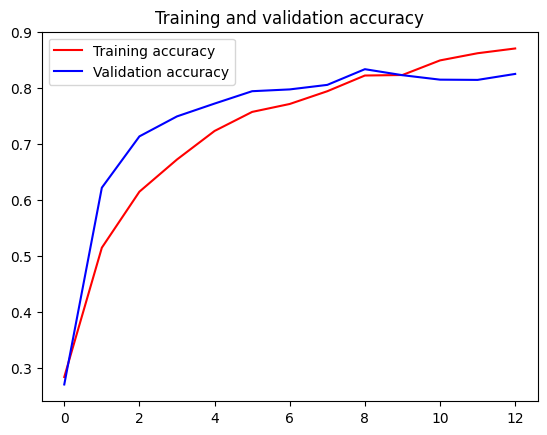

<Figure size 640x480 with 0 Axes>

In [44]:
# Plot the results
acc = model_history.history['custom_f1_score']
val_acc = model_history.history['val_custom_f1_score']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

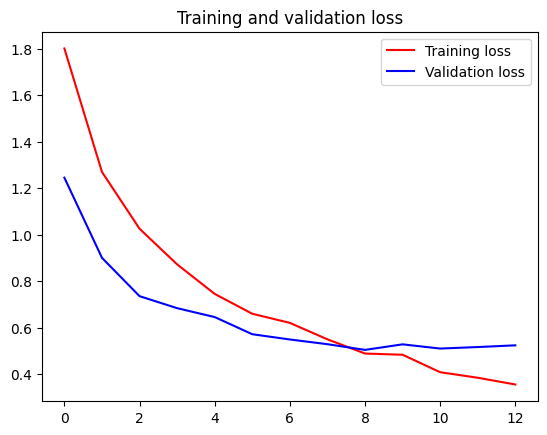

<Figure size 640x480 with 0 Axes>

In [45]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

plt.show()

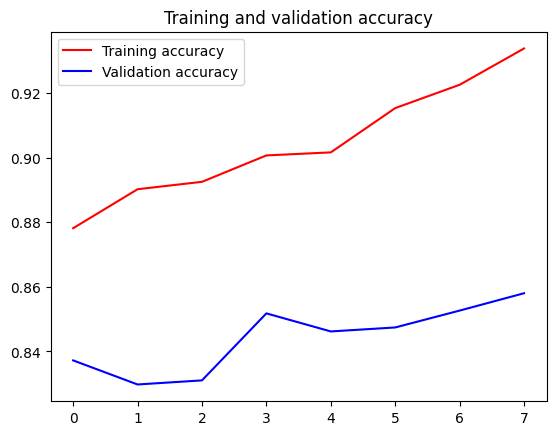

<Figure size 640x480 with 0 Axes>

In [42]:
# Plot the results
acc2 = model_history2.history['custom_f1_score']
val_acc2 = model_history2.history['val_custom_f1_score']

epochs2 = range(len(acc2))

plt.plot(epochs2, acc2, 'r', label='Training accuracy')
plt.plot(epochs2, val_acc2, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

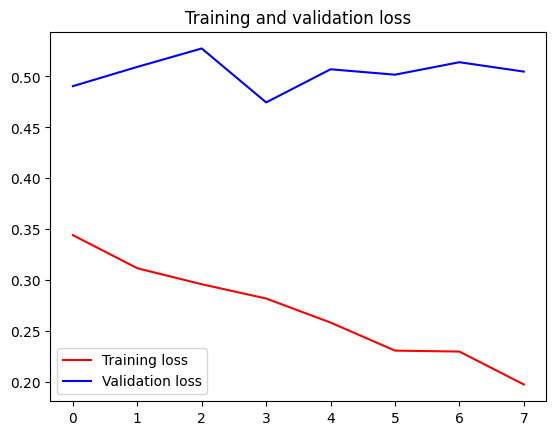

<Figure size 640x480 with 0 Axes>

In [43]:
loss2 = model_history2.history['loss']
val_loss2 = model_history2.history['val_loss']

epochs2 = range(len(loss2))

plt.plot(epochs2, loss2, 'r', label='Training loss')
plt.plot(epochs2, val_loss2, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

plt.show()

## Model Prediction


In [46]:
#from tensorflow.keras.utils import load_img, img_to_array
pr=[]
test_images_path = os.path.join(main_dir, 'images','test_images')
for i in os.listdir(test_images_path):
    path = os.path.join(test_images_path, i)
    img = load_img(path, target_size=(height, wight))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    classes = model.predict(images, batch_size=1)
    pr.append(np.argmax(classes[0]))
    print(np.argmax(classes[0]))

1/1 [==============================] - 1s 1s/step
4
1/1 [==============================] - 0s 63ms/step
1
1/1 [==============================] - 0s 54ms/step
1
1/1 [==============================] - 0s 55ms/step
4
1/1 [==============================] - 0s 60ms/step
1
1/1 [==============================] - 0s 57ms/step
1
1/1 [==============================] - 0s 62ms/step
4
1/1 [==============================] - 0s 63ms/step
2
1/1 [==============================] - 0s 54ms/step
0
1/1 [==============================] - 0s 47ms/step
3
1/1 [==============================] - 0s 62ms/step
0
1/1 [==============================] - 0s 61ms/step
4
1/1 [==============================] - 0s 61ms/step
0
1/1 [==============================] - 0s 63ms/step
4
1/1 [==============================] - 0s 58ms/step
0
1/1 [==============================] - 0s 47ms/step
2
1/1 [==============================] - 0s 53ms/step
2
1/1 [==============================] - 0s 61ms/step
3
1/1 [=========================

In [47]:
test_dict={'image_id':os.listdir(test_images_path),'class_6':pr}
test_data=pd.DataFrame(test_dict)
test_data.to_csv(main_dir+'\\submission_effB0.csv', index=False)

test_csv=pd.read_csv(main_dir+'\\submission_effB0.csv')

print ("data first 10 rows:",'\n',test_csv.head(10),'\n')

data first 10 rows: 
                                image_id  class_6
0  00d0f4ee536e780443bdf452ec614750.jpg        4
1  00f5ce61013130356cf6942836b1d18f.jpg        1
2  0113cd867cbcad38c7817ad1a6fc33ec.jpg        1
3  017b773994b13227de81d3145c4e8837.jpg        4
4  01a34d9b6616d060f29ade56eebc6e2c.jpg        1
5  0201f0b1fb1dd8fa7568a96ffb670ba7.jpg        1
6  032edf429c637c75fad3b5196711b727.jpg        4
7  037230ec9ebcfe4b6532aec7f2bd4e4d.jpg        2
8  03d9672bcec7e1dd13110e4270e2edb0.jpg        0
9  03e42ed7a74bc00b4a0173d169a2b701.jpg        3 

